<a href="https://colab.research.google.com/github/vedharshita/Detecting-Mental-Workload-in-Virtual-Reality/blob/main/3_Spectrogram%2BCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Detecting Cognitive Workload Using Fourier Transform (FFT) and Power Spectral Density (PSD) on Wireless EEG Spectral Data***

---

EEG data is converted into multi-channel spectrogram images, which allows for greater spectral and temporal coefficient correlation, before being fed into a convolutional neural network (CNN). 

In [ ]:
## Mounting gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
## Import Statements
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import scipy.io
from matplotlib.pyplot import specgram

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.utils import class_weight
from collections import Counter
from os import listdir
from os.path import isfile, join

In [ ]:
## Setting path for data files on colab
root_dir = "/content/gdrive/MyDrive/VR Mental Workload/"
raw_dir = root_dir + "data/VRData2019/"
csv_dir = raw_dir + "csv/"
nback_dir = raw_dir + "nback_csv/"
spec_dir = raw_dir + "spec_dir/"
train_dir = spec_dir + "train/"
test_dir = spec_dir + "test/"
os.chdir(nback_dir)

Training:  ['S03', 'S08', 'S14', 'S15', 'S07', 'S06', 'S11', 'S02', 'S05', 'S01']


Testing:  ['S04', 'S09', 'S10', 'S12', 'S13']

In [ ]:
## Training Testing files segregation
p_tr = ['S03', 'S08', 'S14', 'S15', 'S07', 'S06', 'S11', 'S02', 'S05', 'S01']
p_te = ['S04', 'S09', 'S10', 'S12', 'S13']
tr_files = []
te_files = []
lst0 = sorted(os.listdir())
for i in p_tr:
  for file in lst0:
    if file.startswith(i):
      tr_files.append(file)
for i in p_te:
  for file in lst0:
    if file.startswith(i):
      te_files.append(file)

print(tr_files)
print(te_files)

['S03_nback0.csv', 'S03_nback1.csv', 'S03_nback2.csv', 'S08_nback0.csv', 'S08_nback1.csv', 'S08_nback2.csv', 'S14_nback0.csv', 'S14_nback1.csv', 'S14_nback2.csv', 'S15_nback0.csv', 'S15_nback1.csv', 'S15_nback2.csv', 'S07_nback0.csv', 'S07_nback1.csv', 'S07_nback2.csv', 'S06_nback0.csv', 'S06_nback1.csv', 'S06_nback2.csv', 'S11_nback0.csv', 'S11_nback1.csv', 'S11_nback2.csv', 'S02_nback0.csv', 'S02_nback1.csv', 'S02_nback2.csv', 'S05_nback0.csv', 'S05_nback1.csv', 'S05_nback2.csv', 'S01_nback0.csv', 'S01_nback1.csv', 'S01_nback2.csv']
['S04_nback0.csv', 'S04_nback1.csv', 'S04_nback2.csv', 'S09_nback0.csv', 'S09_nback1.csv', 'S09_nback2.csv', 'S10_nback0.csv', 'S10_nback1.csv', 'S10_nback2.csv', 'S12_nback0.csv', 'S12_nback1.csv', 'S12_nback2.csv', 'S13_nback0.csv', 'S13_nback1.csv', 'S13_nback2.csv']


### **STEP 6: Creating Spectrograms for CNN**


In [ ]:
## Creating Spectrograms
def create_Spectogram():
  for i in tr_files:
    os.chdir(nback_dir)
    df = pd.read_csv(i)
    os.chdir(train_dir)
    for j in df.columns[15:]:
      fig, ax = plt.subplots(1,figsize=(12,4))
      ax.specgram(df[j], Fs = 256, cmap = plt.cm.jet)
      ax.set(yticklabels=[], xticklabels=[])
      ax.tick_params(left=False, bottom=False, top=False, right=False )
      ax.axis('off')
      # ax.set_title(i.split("_")[0] + "_" + i.split("_")[1] + "_" +  j + '_Spectrogram')
      # ax.set_ylabel('Freq (Hz)')
      # ax.set_xlabel('Time')

      if("nback0" in i):
        os.chdir(train_dir + "0/")
      elif("nback1" in i):
        os.chdir(train_dir + "1/")
      elif("nback2" in i):
        os.chdir(train_dir + "2/")
      plt.savefig(i.split("_")[0] + "_" + i.split("_")[1] + "_" +  j + "_Spec.png", bbox_inches='tight')

  for i in te_files:
    os.chdir(nback_dir)
    df = pd.read_csv(i)
    os.chdir(test_dir)
    for j in df.columns[15:]:
      fig, ax = plt.subplots(1,figsize=(12,4))
      ax.specgram(df[j], Fs = 256, cmap = plt.cm.jet)
      ax.set(yticklabels=[], xticklabels=[])
      ax.tick_params(left=False, bottom=False, top=False, right=False )
      ax.axis('off')
      # ax.set_title(i.split("_")[0] + "_" + i.split("_")[1] + "_" +  j + '_Spectrogram')
      # ax.set_ylabel('Freq (Hz)')
      # ax.set_xlabel('Time')

      if("nback0" in i):
        os.chdir(test_dir + "0/")
      elif("nback1" in i):
        os.chdir(test_dir + "1/")
      elif("nback2" in i):
        os.chdir(test_dir + "2/")
      plt.savefig(i.split("_")[0] + "_" + i.split("_")[1] + "_" +  j + "_Spec.png", bbox_inches='tight')

create_Spectogram()

### **STEP 7: Feeding Spectrograms in CNN**


In [ ]:
## Loading Input images
os.chdir(train_dir)
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory=train_dir, target_size=(224,224))
os.chdir(test_dir)
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory=test_dir, target_size=(224,224))

Found 240 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


In [ ]:
## Feeding into VGG16 
vgg16 = VGG16(weights='imagenet')
vgg16.summary()

x  = vgg16.get_layer('fc2').output
prediction = Dense(3, activation='softmax', name='predictions')(x)

model = Model(inputs=vgg16.input, outputs=prediction)

553467904/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
## Trainable and non-Trainable parameters
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-20:]:
    layer.trainable = True
    print("Layer '%s' is trainable" % layer.name) 

Layer 'block1_pool' is trainable
Layer 'block2_conv1' is trainable
Layer 'block2_conv2' is trainable
Layer 'block2_pool' is trainable
Layer 'block3_conv1' is trainable
Layer 'block3_conv2' is trainable
Layer 'block3_conv3' is trainable
Layer 'block3_pool' is trainable
Layer 'block4_conv1' is trainable
Layer 'block4_conv2' is trainable
Layer 'block4_conv3' is trainable
Layer 'block4_pool' is trainable
Layer 'block5_conv1' is trainable
Layer 'block5_conv2' is trainable
Layer 'block5_conv3' is trainable
Layer 'block5_pool' is trainable
Layer 'flatten' is trainable
Layer 'fc1' is trainable
Layer 'fc2' is trainable
Layer 'predictions' is trainable


In [ ]:
## Model Summary
opt = Adam(lr=0.000001)
model.compile(optimizer=opt, loss=categorical_crossentropy, 
              metrics=['accuracy', 'mae'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
## Model Checkpoint and Early stopping criteria
checkpoint = ModelCheckpoint("vgg16_base_res.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [ ]:
## Class weights
counter = Counter(traindata.classes)                       
max_val = float(max(counter.values()))   
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 1.0, 1: 1.0, 2: 1.0}

In [ ]:
testdata.samples

120

In [ ]:
## 1. Fitting the model with Model Checkpoint and Early stopping criteria
hist = model.fit(traindata, steps_per_epoch=traindata.samples//traindata.batch_size, validation_data=testdata, 
                 class_weight=class_weights, validation_steps=testdata.samples//testdata.batch_size, 
                 epochs=110,callbacks=[checkpoint,early])

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/110
7/7 [==============================] - 91s 8s/step - loss: 1.4257 - accuracy: 0.2596 - mae: 0.4624 - val_loss: 1.2972 - val_accuracy: 0.3125 - val_mae: 0.4508

Epoch 00001: val_accuracy improved from -inf to 0.31250, saving model to vgg16_base_res.h5
Epoch 2/110
7/7 [==============================] - 8s 1s/step - loss: 1.1622 - accuracy: 0.3798 - mae: 0.4307 - val_loss: 1.1899 - val_accuracy: 0.3125 - val_mae: 0.4466

Epoch 00002: val_accuracy did not improve from 0.31250
Epoch 3/110
7/7 [==============================] - 4s 588ms/step - loss: 1.0090 - accuracy: 0.5048 - mae: 0.4109 - val_loss: 1.1449 - val_accuracy: 0.2917 - val_mae: 0.4445

Epoch 00003: val_accuracy did not improve from 0.31250
Epoch 4/110
7/7 [==============================] - 4s 546ms/step - loss: 0.9751 - accuracy: 0.5000 - mae: 0.3987 - val_loss: 1.1651 - val_accura

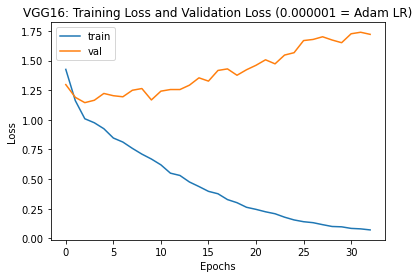

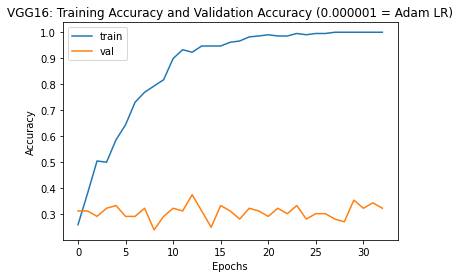

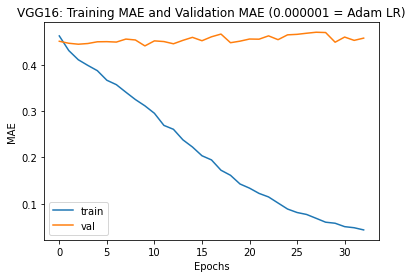

In [ ]:
## Making plots for condition 1
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('VGG16: Training Loss and Validation Loss (0.000001 = Adam LR)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend();
plt.show()

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('VGG16: Training Accuracy and Validation Accuracy (0.000001 = Adam LR)')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend();
plt.show()

plt.plot(hist.history['mae'], label='train')
plt.plot(hist.history['val_mae'], label='val')
plt.title('VGG16: Training MAE and Validation MAE (0.000001 = Adam LR)')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend();
plt.show()

In [ ]:
testdata.samples//testdata.batch_size + 1

4

In [ ]:
Y_pred = model.predict(testdata, testdata.samples//testdata.batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testdata.classes, y_pred))
print('Classification Report')
# target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(testdata.classes, y_pred))

Confusion Matrix
[[12 19  9]
 [12 19  9]
 [ 6 23 11]]
Classification Report
              precision    recall  f1-score   support

           0       0.40      0.30      0.34        40
           1       0.31      0.47      0.38        40
           2       0.38      0.28      0.32        40

    accuracy                           0.35       120
   macro avg       0.36      0.35      0.35       120
weighted avg       0.36      0.35      0.35       120



In [ ]:
## 2. Fitting the model without Model Checkpoint and Early stopping criteria
hist1 = model.fit(traindata, steps_per_epoch=traindata.samples//traindata.batch_size, validation_data=testdata, 
                 class_weight=class_weights, validation_steps=testdata.samples//testdata.batch_size, 
                 epochs=110,callbacks=None)

Epoch 1/110
7/7 [==============================] - 4s 540ms/step - loss: 0.0596 - accuracy: 1.0000 - mae: 0.0371 - val_loss: 1.7746 - val_accuracy: 0.2708 - val_mae: 0.4667
Epoch 2/110
7/7 [==============================] - 4s 539ms/step - loss: 0.0556 - accuracy: 1.0000 - mae: 0.0346 - val_loss: 1.7574 - val_accuracy: 0.3021 - val_mae: 0.4599
Epoch 3/110
7/7 [==============================] - 4s 508ms/step - loss: 0.0503 - accuracy: 1.0000 - mae: 0.0317 - val_loss: 1.9075 - val_accuracy: 0.2917 - val_mae: 0.4692
Epoch 4/110
7/7 [==============================] - 4s 550ms/step - loss: 0.0415 - accuracy: 1.0000 - mae: 0.0263 - val_loss: 1.9399 - val_accuracy: 0.2708 - val_mae: 0.4759
Epoch 5/110
7/7 [==============================] - 4s 508ms/step - loss: 0.0441 - accuracy: 1.0000 - mae: 0.0274 - val_loss: 1.9697 - val_accuracy: 0.2812 - val_mae: 0.4707
Epoch 6/110
7/7 [==============================] - 4s 532ms/step - loss: 0.0390 - accuracy: 1.0000 - mae: 0.0246 - val_loss: 1.8159 - v

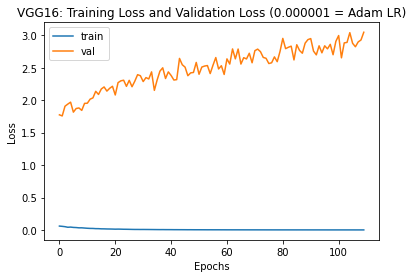

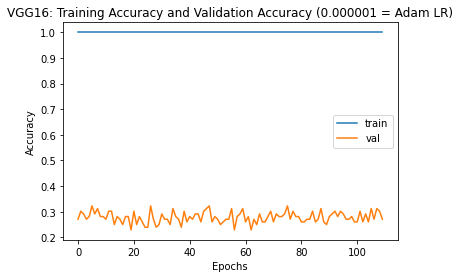

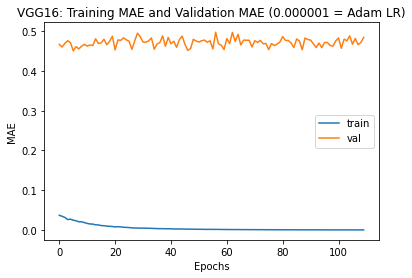

In [ ]:
## Making plots for condition 2
plt.plot(hist1.history['loss'], label='train')
plt.plot(hist1.history['val_loss'], label='val')
plt.title('VGG16: Training Loss and Validation Loss (0.000001 = Adam LR)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend();
plt.show()

plt.plot(hist1.history['accuracy'], label='train')
plt.plot(hist1.history['val_accuracy'], label='val')
plt.title('VGG16: Training Accuracy and Validation Accuracy (0.000001 = Adam LR)')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend();
plt.show()

plt.plot(hist1.history['mae'], label='train')
plt.plot(hist1.history['val_mae'], label='val')
plt.title('VGG16: Training MAE and Validation MAE (0.000001 = Adam LR)')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend();
plt.show()

In [ ]:
Y_pred = model.predict(testdata, testdata.samples//testdata.batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testdata.classes, y_pred))
print('Classification Report')
# target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(testdata.classes, y_pred))

Confusion Matrix
[[10 18 12]
 [14 14 12]
 [ 9 24  7]]
Classification Report
              precision    recall  f1-score   support

           0       0.30      0.25      0.27        40
           1       0.25      0.35      0.29        40
           2       0.23      0.17      0.20        40

    accuracy                           0.26       120
   macro avg       0.26      0.26      0.25       120
weighted avg       0.26      0.26      0.25       120

